# Zadanie 1 - Strategie dla ryzyka związanego z ceną miedzi

[*********************100%***********************]  1 of 1 completed


Aktualna cena miedzi: 4.83 USD/lb
Oszacowana zmienność roczna: 24.00%
Premia opcyjna: 0.2542 USD/lb (łącznie: 254.17 USD)


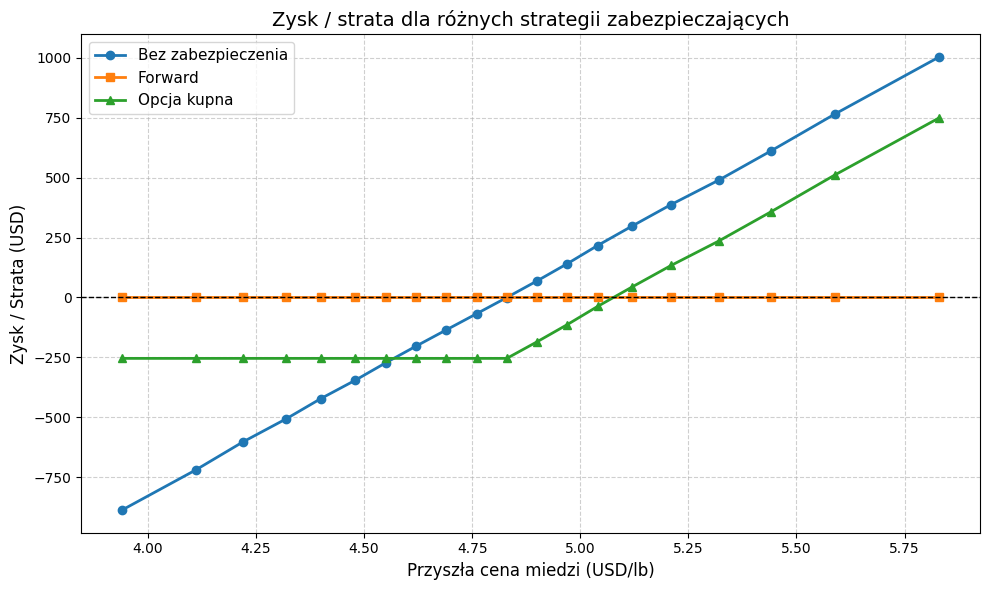


Value at Risk (VaR 95%) – strategia z opcją: -254.17 USD

Tabela strategii:



,Przyszła cena miedzi (USD/lb),Koszt: Bez zabezp. (USD),Zysk/Strata: Bez zabezp. (USD),Koszt: Forward (USD),Zysk/Strata: Forward (USD),Koszt: Opcja kupna (USD),Zysk/Strata: Opcja kupna (USD)
0,3.94,3938.78,-887.22,4826.00,0.00,4571.83,-254.17
1,4.11,4105.66,-720.34,4826.00,0.00,4571.83,-254.17
2,4.22,4223.50,-602.50,4826.00,0.00,4571.83,-254.17
3,4.32,4319.77,-506.23,4826.00,0.00,4571.83,-254.17
4,4.40,4404.08,-421.92,4826.00,0.00,4571.83,-254.17
5,4.48,4481.05,-344.95,4826.00,0.00,4571.83,-254.17
6,4.55,4553.36,-272.64,4826.00,0.00,4571.83,-254.17
7,4.62,4622.80,-203.20,4826.00,0.00,4571.83,-254.17
8,4.69,4690.66,-135.34,4826.00,0.00,4571.83,-254.17
9,4.76,4758.04,-67.96,4826.00,0.00,4571.83,-254.17


In [100]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parametry
ticker = 'HG=F'
notional = 1000  # funty miedzi
T = 90 / 365  # 90 dni
r = 0.0425  # stopa wolna od ryzyka

data = yf.download(ticker, period='6y')['Close']
S0 = data.iloc[-1].item()
log_returns = np.ravel(np.log(data / data.shift(1)).dropna())
sigma = np.std(log_returns) * np.sqrt(252)
print(f'Aktualna cena miedzi: {S0:.2f} USD/lb')
print(f'Oszacowana zmienność roczna: {sigma:.2%}')

# Kwantyle – możliwe przyszłe ceny
quantiles = np.linspace(0.05, 0.95, 20)
future_prices = S0 * np.exp(norm.ppf(quantiles) * sigma * np.sqrt(T) - 0.5 * sigma**2 * T)

# Premia opcyjna
def call_option_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

K = S0  # Strike = dzisiejsza cena
call_premium = call_option_price(S0, K, T, r, sigma)
premium_total = call_premium * notional
print(f'Premia opcyjna: {call_premium:.4f} USD/lb (łącznie: {premium_total:.2f} USD)')

# Tworzenie tabeli
rows = []
for price in future_prices:
    # Koszt bez zabezpieczenia
    cost_unhedged = price * notional
    pnl_unhedged = cost_unhedged - S0 * notional

    # Koszt forward (z góry ustalona cena)
    cost_forward = K * notional
    pnl_forward = cost_forward - S0 * notional

    # Koszt z opcją
    cost_option = max(price, K) * notional - premium_total
    pnl_option = cost_option - S0 * notional

    rows.append([
        round(price, 2),
        round(cost_unhedged, 2), round(pnl_unhedged, 2),
        round(cost_forward, 2), round(pnl_forward, 2),
        round(cost_option, 2), round(pnl_option, 2)
    ])

df = pd.DataFrame(rows, columns=[
    'Przyszła cena miedzi (USD/lb)',
    'Koszt: Bez zabezp. (USD)', 'Zysk/Strata: Bez zabezp. (USD)',
    'Koszt: Forward (USD)', 'Zysk/Strata: Forward (USD)',
    'Koszt: Opcja kupna (USD)', 'Zysk/Strata: Opcja kupna (USD)'
])

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Bez zabezp. (USD)'], label='Bez zabezpieczenia', marker='o', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Forward (USD)'], label='Forward', marker='s', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Opcja kupna (USD)'], label='Opcja kupna', marker='^', linewidth=2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Zysk / strata dla różnych strategii zabezpieczających', fontsize=14)
plt.xlabel('Przyszła cena miedzi (USD/lb)', fontsize=12)
plt.ylabel('Zysk / Strata (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

def style_table(df):
    styles = []

    # Białe kontury dla wszystkich komórek i nagłówków
    styles.append({
        'selector': 'th, td',
        'props': [('border', '0.5px solid white')]
    })

    # Gruba biała linia pionowa po pierwszej kolumnie (przyszła cena)
    styles.append({
        'selector': 'td.col0, th.col0',
        'props': [('border-right', '4px solid white')]
    })

    # Grube białe linie pionowe po kolumnach 2 i 4 (0-based)
    styles.append({
        'selector': 'td.col2, th.col2',
        'props': [('border-right', '4px solid white')]
    })
    styles.append({
        'selector': 'td.col4, th.col4',
        'props': [('border-right', '4px solid white')]
    })

    # Pogrubienie nagłówków
    styles.append({
        'selector': 'th',
        'props': [('font-weight', 'bold')]
    })

    return df.style.format(precision=2).set_table_styles(styles)


# Obliczenie VaR dla opcji
pnl_option_all = df['Zysk/Strata: Opcja kupna (USD)'].values
VaR = np.percentile(pnl_option_all, 5)
print(f'\nValue at Risk (VaR 95%) – strategia z opcją: {VaR:.2f} USD')

print('\nTabela strategii:\n')
styled_df = style_table(df)
styled_df


In [101]:
price_today = S0*notional
costs_df = df.iloc[:,[1,3,5]]
price_today #cena opcji kupna
premium_total # premia 

for i in range(len(df)):
    if costs_df.loc[i,"Koszt: Bez zabezp. (USD)"] < price_today:
        costs_df.loc[i,"Koszt: Opcja kupna (USD)"] = costs_df.loc[i,"Koszt: Bez zabezp. (USD)"] + premium_total
    else:
        costs_df.loc[i,"Koszt: Opcja kupna (USD)"] = price_today + premium_total

profit_loss_df = pd.DataFrame(columns=['Zysk/strata: bez zabezp.','Zysk/strata: forward', 'Zysk/strata: opcja'])

for i in range(len(costs_df)):
    new_row = {'Zysk/strata: bez zabezp.': price_today-costs_df.loc[i,"Koszt: Bez zabezp. (USD)"],
                'Zysk/strata: forward': -(price_today-costs_df.loc[i,"Koszt: Bez zabezp. (USD)"]),
                'Zysk/strata: opcja': costs_df.loc[i,"Koszt: Bez zabezp. (USD)"]-costs_df.loc[i,"Koszt: Opcja kupna (USD)"]}
    profit_loss_df = pd.concat([profit_loss_df, pd.DataFrame([new_row])], ignore_index=True)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7052\789386688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costs_df.loc[i,"Koszt: Opcja kupna (USD)"] = costs_df.loc[i,"Koszt: Bez zabezp. (USD)"] + premium_total
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7052\789386688.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costs_df.loc[i,"Koszt: Opcja kupna (USD)"] = price_today + premium_total
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7052\789386688.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or 

In [105]:
def color_risk(val):
    if val < price_today:
        color = 'lightgreen'
    elif val > price_today:
        color = "red"
    else:
        color = "white"
    return f'color: {color}'

def color_option(val):
    if val < price_today:
        color = 'lightgreen'
    elif val > price_today:
        color = "red"
    else:
        color = "white"
    return f'color: {color}'



color_df = costs_df.style.applymap(color_risk, subset=costs_df.columns[[0,2]])

def highlight_forward(row):
    if row["Koszt: Forward (USD)"] > row["Koszt: Bez zabezp. (USD)"]:
        return [''] * 1 + ['color: red'] + [''] * 1
    else:
        return [''] * 1 + ['color: lightgreen'] + [''] * 1
    
color_df = costs_df.style.apply(highlight_forward, axis=1)
color_df = (
    costs_df.style
      .apply(highlight_forward, axis=1)
      .applymap(color_risk, subset=costs_df.columns[[0,2]])
)
display(color_df.hide(axis="index")) # wypisanie bez indeksu
display(profit_loss_df)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7052\2710216622.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  color_df = costs_df.style.applymap(color_risk, subset=costs_df.columns[[0,2]])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7052\2710216622.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_risk, subset=costs_df.columns[[0,2]])


Koszt: Bez zabezp. (USD),Koszt: Forward (USD),Koszt: Opcja kupna (USD)
3938.780000,4826.000000,4192.954347
4105.660000,4826.000000,4359.834347
4223.500000,4826.000000,4477.674347
4319.770000,4826.000000,4573.944347
4404.080000,4826.000000,4658.254347
4481.050000,4826.000000,4735.224347
4553.360000,4826.000000,4807.534347
4622.800000,4826.000000,4876.974347
4690.660000,4826.000000,4944.834347
4758.040000,4826.000000,5012.214347


,Zysk/strata: bez zabezp.,Zysk/strata: forward,Zysk/strata: opcja
0,887.220214,-887.220214,-254.174347
1,720.340214,-720.340214,-254.174347
2,602.500214,-602.500214,-254.174347
3,506.230214,-506.230214,-254.174347
4,421.920214,-421.920214,-254.174347
5,344.950214,-344.950214,-254.174347
6,272.640214,-272.640214,-254.174347
7,203.200214,-203.200214,-254.174347
8,135.340214,-135.340214,-254.174347
9,67.960214,-67.960214,-254.174347


# Inne miary wrażliwości dla strategii z opcją kupna

In [103]:
from scipy.stats import norm
import numpy as np

def option_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # na 1% zmienności
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    theta /= 365  # dzienna theta
    rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100  # na 1% zmiany stopy

    return delta, gamma, vega, theta, rho

# Parametry (przykład)
S = S0  # cena miedzi
K = S0  # strike = cena obecna
T = 30 / 365
r = 0.05
sigma = sigma

delta, gamma, vega, theta, rho = option_greeks(S, K, T, r, sigma)

print(f'Delta: {delta:.4f}')
print(f'Gamma: {gamma:.6f}')
print(f'Vega: {vega:.4f}')
print(f'Theta (dzienna): {theta:.4f}')
print(f'Rho: {rho:.4f}')


Delta: 0.5375
Gamma: 1.195997
Vega: 0.0055
Theta (dzienna): -0.0025
Rho: 0.0020


* **Delta** – wrażliwość ceny opcji na zmianę ceny instrumentu bazowego,
* **Gamma** – wrażliwość delty na zmianę ceny instrumentu bazowego,
* **Vega** – wrażliwość ceny opcji na zmianę zmienności (sigma),
* **Theta** – wrażliwość ceny opcji na upływ czasu,
* **Rho** – wrażliwość ceny opcji na zmianę stopy procentowej.

**Wyjaśnienie:**

* *Delta* bliska 0–1, mówi jak bardzo zmieni się cena opcji jeśli cena miedzi zmieni się o 1 USD.
* *Gamma* informuje, jak szybko zmienia się delta przy zmianie ceny instrumentu.
* *Vega* pokazuje, jak cena opcji zmienia się przy wzroście zmienności o 1 punkt procentowy.
* *Theta* mówi, ile opcji „traci” na wartości każdego dnia (koszt upływu czasu).
* *Rho* pokazuje wrażliwość opcji na zmianę stóp procentowych.



# <font color='deepskyblue'>Zadanie 2: Szacowanie Prawdopodobieństwa Niewypłacalności w Modelu KMV</font>

W tej części projektu ocenimy ryzyko kredytowe dwóch kluczowych dostawców Nvidii: **TSMC** oraz **Samsung Electronics**.  
Wykorzystamy do tego celu **model KMV**, który jest praktycznym zastosowaniem modelu Mertona do oceny prawdopodobieństwa niewypłacalności (*Probability of Default*, $PD$).


# <font color='lightgreen'>Wprowadzenie Teoretyczne - Model Mertona</font>

Model Mertona traktuje kapitał własny firmy (*Equity*) jako opcję kupna (*call option*) na aktywa tej firmy (*Assets*). Dług firmy (*Debt*) pełni rolę ceny wykonania (*strike price*) tej opcji.

Jeśli wartość aktywów $V$ w momencie zapadalności długu $T$ jest wyższa niż wartość długu $D$, właściciele "wykonują opcję" – spłacają dług i zatrzymują pozostałą wartość aktywów $V - D$.  
Jeśli wartość aktywów jest niższa niż dług, właściciele pozwalają opcji wygasnąć – ogłaszają bankructwo, a wierzyciele przejmują aktywa firmy.  
Niewypłacalność następuje, gdy $V_T < D$.

## Kluczowe równania modelu

Do wyznaczenia wartości aktywów $V$ i ich zmienności $\sigma_A$, które nie są bezpośrednio obserwowalne, rozwiązujemy układ dwóch nieliniowych równań:

$$
\begin{cases}
E = V \cdot N(d_1) - D \cdot e^{-rT} \cdot N(d_2) \\
\sigma_E \cdot E = \sigma_A \cdot V \cdot N(d_1)
\end{cases}
$$

gdzie:

$$
d_1 = \frac{\ln(V/D) + (r + 0.5 \cdot \sigma_A^2) \cdot T}{\sigma_A \sqrt{T}}, \quad
d_2 = d_1 - \sigma_A \sqrt{T}
$$

### Zmienne:

- $E$ – Kapitalizacja rynkowa (wartość kapitału własnego)  
- $\sigma_E$ – Zmienność kapitału własnego (obserwowana na rynku akcji)  
- $D$ – Próg niewypłacalności (wartość długu)  
- $r$ – Stopa wolna od ryzyka  
- $T$ – Horyzont czasowy (zwykle 1 rok)  
- $V$ – Wartość aktywów firmy (niewiadoma)  
- $\sigma_A$ – Zmienność aktywów firmy (niewiadoma)  
- $N(\cdot)$ – Dystrybuanta standardowego rozkładu normalnego


# <font color='lightgreen'> Przygotowanie Danych Wejściowych</font>

Na podstawie danych rynkowych i finansowych z pierwszego kwartału 2025 roku, zbieramy następujące informacje:

| **Wielkość (stan na 31 III 2025)**                  | **Źródło**               | **TSMC**                      | **Samsung Electronics**            |
|------------------------------------------------------|---------------------------|--------------------------------|------------------------------------|
| Kapitalizacja rynkowa ($E$)                          | notowania giełdowe        | 880 mld USD                   | 384 mld USD                        |
| Zobowiązania ogółem                                  | raporty finansowe         | 2 143 736 mln NTD (≈ 66 mld USD) | 112 340 mld KRW (≈ 82 mld USD)    |
| Stopa wolna od ryzyka ($r$)                          | rentowność US 1Y Treasury | 4.25%                          | 4.25%                              |
| Horyzont czasowy ($T$)                               | założenie modelu          | 1 rok                          | 1 rok                              |

---

### Próg niewypłacalności (Default Point, $D$):

Model KMV często definiuje próg niewypłacalności jako sumę zobowiązań krótkoterminowych i połowę zobowiązań długoterminowych.  
Z powodu braku szczegółowego rozbicia w dostępnych raportach, stosujemy konserwatywne uproszczenie:

$$
D \approx 0.5 \times \text{Zobowiązania ogółem}
$$


In [104]:
# Import niezbędnych bibliotek
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from mpmath import findroot  # Solver do układów równań nieliniowych
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import fsolve # Używamy solwera z biblioteki SciPy
import warnings

# Ustawienia wizualne
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Krok 1: Definicja danych wejściowych
# ------------------------------------

# Dane dla TSMC
E_tsmc = 880e9  # 880 mld USD
L_tsmc = 66e9   # 66 mld USD (Total Liabilities)
D_tsmc = 0.5 * L_tsmc # Próg niewypłacalności

# Dane dla Samsung Electronics
E_samsung = 384e9  # 384 mld USD
L_samsung = 82e9   # 82 mld USD (Total Liabilities)
D_samsung = 0.5 * L_samsung # Próg niewypłacalności

# Parametry wspólne
r = 0.0425  # 4.25% stopa wolna od ryzyka
T = 1.0     # Horyzont 1 roku

print("--- DANE WEJŚCIOWE DO MODELU ---")
print(f"TSMC:")
print(f"  Kapitalizacja (E): {E_tsmc/1e9:.2f} mld USD")
print(f"  Próg niewypłacalności (D): {D_tsmc/1e9:.2f} mld USD")
print(f"\nSamsung Electronics:")
print(f"  Kapitalizacja (E): {E_samsung/1e9:.2f} mld USD")
print(f"  Próg niewypłacalności (D): {D_samsung/1e9:.2f} mld USD")

ModuleNotFoundError: No module named 'mpmath'

Zmienność kapitału własnego ($\sigma_E$) szacujemy jako **roczne odchylenie standardowe logarytmicznych stóp zwrotu z akcji** danej spółki,  
na podstawie danych historycznych (np. z ostatnich 3 lat).


In [ ]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# --- Funkcje Pomocnicze ---

def equity_sigma(ticker: str, years: int = 3) -> float:
    """Oblicza roczną zmienność log-zwrotów dla danego tickera."""
    df = yf.download(ticker, period=f'{years}y', auto_adjust=True, progress=False)
    px = df['Close'].dropna()
    log_returns = np.log(px / px.shift(1)).dropna()
    sigma = log_returns.std() * np.sqrt(252)
    return sigma.item()  # Zwraca czystą liczbę (float)

def solve_merton(E, sigma_E, D, r=0.0425, T=1.0):
    """Rozwiązuje układ równań Mertona, aby znaleźć V i sigma_A."""
    def equations(vars):
        V, sigma_A = vars
        # Zabezpieczenie przed wartościami niedozwolonymi dla logarytmu i pierwiastka
        if V <= 0 or sigma_A <= 0:
            return (1e9, 1e9)
            
        d1 = (np.log(V / D) + (r + 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
        d2 = d1 - sigma_A * np.sqrt(T)
        
        eq1 = V * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2) - E
        eq2 = sigma_A * V * norm.cdf(d1) - sigma_E * E
        return (eq1, eq2)

    # Początkowe przybliżenia dla solwera
    V0, s0 = E + D, sigma_E
    
    # Użycie fsolve do znalezienia rozwiązania
    V, sigma_A = fsolve(equations, (V0, s0), xtol=1e-10)
    return V, sigma_A

def distance_to_default(V, sigma_A, D, r=0.0425, T=1.0):
    """Oblicza Distance-to-Default (DD) i Probability of Default (PD)."""
    DD = (np.log(V / D) + (r - 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
    PD = norm.cdf(-DD)
    return DD, PD

Mając zdefiniowane funkcje, przygotowujemy słownik z danymi wejściowymi dla TSMC i Samsunga, a następnie w pętli wykonujemy wszystkie niezbędne obliczenia, zapisując wyniki z powrotem w słowniku.

In [ ]:
# --- Dane Wejściowe ---
data_dict = {
    'TSMC':    {'E': 880e9, 'Liab': 66e9, 'ticker': 'TSM'},
    'Samsung': {'E': 384e9, 'Liab': 82e9, 'ticker': '005930.KS'}
}
r, T = 0.0425, 1.0 # Stopa wolna od ryzyka i horyzont czasowy

# --- Główna Pętla Obliczeniowa ---
print("Uruchamiam obliczenia dla obu firm...")

for firm, info in data_dict.items():
    print(f"  Przetwarzam: {firm}...")
    # Krok 1: Oblicz próg niewypłacalności
    info['D'] = 0.5 * info['Liab']
    
    # Krok 2: Oblicz zmienność kapitału własnego
    info['sigma_E'] = equity_sigma(info['ticker'])
    
    # Krok 3: Rozwiąż równania Mertona dla V i sigma_A
    info['V'], info['sigma_A'] = solve_merton(
        info['E'], info['sigma_E'], info['D'], r, T
    )
    
    # Krok 4: Oblicz DD i PD
    info['DD'], info['PD'] = distance_to_default(
        info['V'], info['sigma_A'], info['D'], r, T
    )

print("\n✓ Obliczenia zakończone pomyślnie.")

Uruchamiam obliczenia dla obu firm...
  Przetwarzam: TSMC...
  Przetwarzam: Samsung...

✓ Obliczenia zakończone pomyślnie.


Wyniki modelu dla obu firm przedstawiamy w zbiorczej tabeli oraz na wykresie słupkowym porównującym ich roczne prawdopodobieństwo niewypłacalności (PD).

,E_mld,Liab_mld,D_mld,sigma_E,sigma_A,DD,PD
TSMC,880,66,33,38.85%,37.50%,8.78,0.0000%
Samsung,384,82,41,27.18%,24.65%,9.52,0.0000%


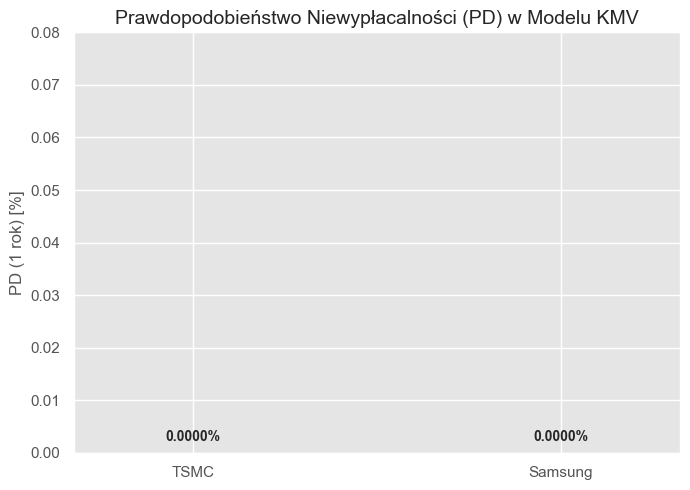

In [ ]:
# --- Prezentacja Wyników w Tabeli ---
# Konwersja słownika wyników na elegancką tabelę w Pandas
out_df = (pd.DataFrame(data_dict).T
          .assign(E_mld=lambda d: d.E / 1e9,
                  Liab_mld=lambda d: d.Liab / 1e9,
                  D_mld=lambda d: d.D / 1e9)
          .loc[:, ['E_mld', 'Liab_mld', 'D_mld', 'sigma_E', 'sigma_A', 'DD', 'PD']])

# Wyświetlenie sformatowanej tabeli
display(out_df.style.format({
    'E_mld': '{:.0f}', 'Liab_mld': '{:.0f}', 'D_mld': '{:.0f}',
    'sigma_E': '{:.2%}', 'sigma_A': '{:.2%}',
    'DD': '{:.2f}', 'PD': '{:.4%}'
}).set_caption("Tabela – wyniki modelu KMV (T = 1 rok)"))


# --- Wizualizacja Porównawcza PD ---
# Przygotowanie danych do wykresu
pd_values_percent = out_df['PD'].astype(float).values * 100
company_names = out_df.index

# Zabezpieczenie na wypadek bardzo małych wartości PD dla estetyki wykresu
safe_top_limit = max(pd_values_percent.max() * 1.4, 0.08)

# Tworzenie wykresu
plt.figure(figsize=(7, 5))
bars = plt.bar(company_names, pd_values_percent, color=['skyblue', 'steelblue'], width=0.5)

# Dodawanie etykiet nad słupkami
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + safe_top_limit * 0.02,
             f"{height:.4f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Prawdopodobieństwo Niewypłacalności (PD) w Modelu KMV', fontsize=14)
plt.ylabel('PD (1 rok) [%]', fontsize=12)
plt.ylim(0, safe_top_limit)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

### Wnioski z modelu KMV (T = 1 rok)

* Dla obu kontrahentów PD(1 Y) ≈ 0 % – wartości praktycznie zerowe.
* Powód: **E ≫ D oraz krótki horyzont** ⇒ bardzo wysoki Distance-to-Default  
  (TSMC ≈ 8,8; Samsung ≈ 9,5).
* Wniosek operacyjny dla Nvidii: **ryzyko kredytowe dostawców jest zaniedbywalne** w skali jednego roku, więc nie wymaga natychmiastowego credit enhancement.
* Uwaga metodologiczna: przy dłuższym horyzoncie (T > 1 rok) lub wyższym progu defaultu (np. ST + ½ LT) PD rośnie do wartości < 1 %, ale wciąż pozostaje niskie.
